In [1]:
import os
import glob
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from colorama import Fore, Style
from torchvision import transforms
from torchvision.models import resnet18, resnet50
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
class HandSignDataset(Dataset):
    def __init__(self, root_dir, image_transforms=None):
        super(Dataset, HandSignDataset).__init__(self)
        self.root_dir = root_dir
        self.image_transforms = image_transforms
        self.parsed_images = self.parse_image_paths()
        self.images, self.labels = self.generate_labels(self.parsed_images)
        self.mapped_1hot_labels = self.category_to_value(self.labels)
    
    def parse_image_paths(self):
        im_paths = {}
        # Loop over integers 0 to 9
        for num in range(10):
            # Create specimen (sample) name in the format 01, 02, 03, ...
            specimen = f"{num:02d}"
            # Parse all the sub folders from each specimen ("./leapGestRecog/00/*")
            subfolders = glob.glob(os.path.join(self.root_dir, specimen, "*"))
            # Above line should return list of 10 sub folders,
            # Loop over each sub folder
            for folder in subfolders:
                # folder eg. ("./leapGestRecog/00/01_palm/")
                # Split at "_", and take the tail as category name
                category = folder.split("_", 1)[-1]
                # create a key in dictonary with category name and empty list as value
                im_paths.setdefault(category, [])
                # Parse all the items from this sub folder
                images_paths = glob.glob(os.path.join(folder, "*"))
                # Append all the image paths to the category key from dict.
                im_paths[category].append(images_paths)

        # Image paths can be list of lists, concatenate them.
        im_paths = {key: sum(val, []) for key, val in im_paths.items()}
        return im_paths
    
    def generate_labels(self, parsed_dict):
        # repeat the same category for #paths times, acts as label for each path
        labels = np.array(sum([[category] * len(paths) for category, paths in parsed_dict.items()], []))
        # concatenate all category images
        im_paths = np.array(sum(list(parsed_dict.values()), []))
        # Check if #labels match #image paths
        assert len(labels) == len(im_paths), "Mismatch between #labels and #im_paths!"
        n_images = len(labels)
        # Obtain a shuffled indices
        permuted_idx = np.random.permutation(n_images)
        # Randomise the images and labels using permuted indices
        return im_paths[permuted_idx], labels[permuted_idx]
    
    def category_to_value(self, labels):
        # categories
        cats = ["palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c", "down"]
        # mapper maps from category name to numeric value
        self.mapper = dict(zip(cats, list(range(len(cats)))))
        # inverse of mapper
        self.inv_mapper = dict(zip(list(range(len(cats))), cats))
        # perform mapping and convert to tensors
        label_values = torch.tensor([self.mapper[cat] for cat in labels])
        # perform one hot encoding on numeric values
        one_hot_labels = torch.nn.functional.one_hot(label_values).float()
        return one_hot_labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # Open the image from path using PIL
        im = Image.open(self.images[index]).convert("L")
        # retrieve the one hot encoded label
        lbl = self.mapped_1hot_labels[index]

        # Perform transformations if any.
        if self.image_transforms:
            im = self.image_transforms(im)
        
        return im, lbl

In [3]:
# Compose the image transformations
im_transforms = transforms.Compose([
    # Resize each image to 224x224 pixels
    transforms.Resize((224, 224)),
    # Convert them to tensor format
    transforms.ToTensor()
])

# Create a dataset instance from dataset class
dataset = HandSignDataset("./leapGestRecog/", image_transforms=im_transforms)

In [4]:
# Retrieve the first item from training set
im_, lb_ = dataset[0]
# Print the shapes
print("Image shape:", im_.shape)
print("Label shape:", lb_.shape)

Image shape: torch.Size([1, 224, 224])
Label shape: torch.Size([10])


Text(0.5, 0.98, 'Sample images from dataset')

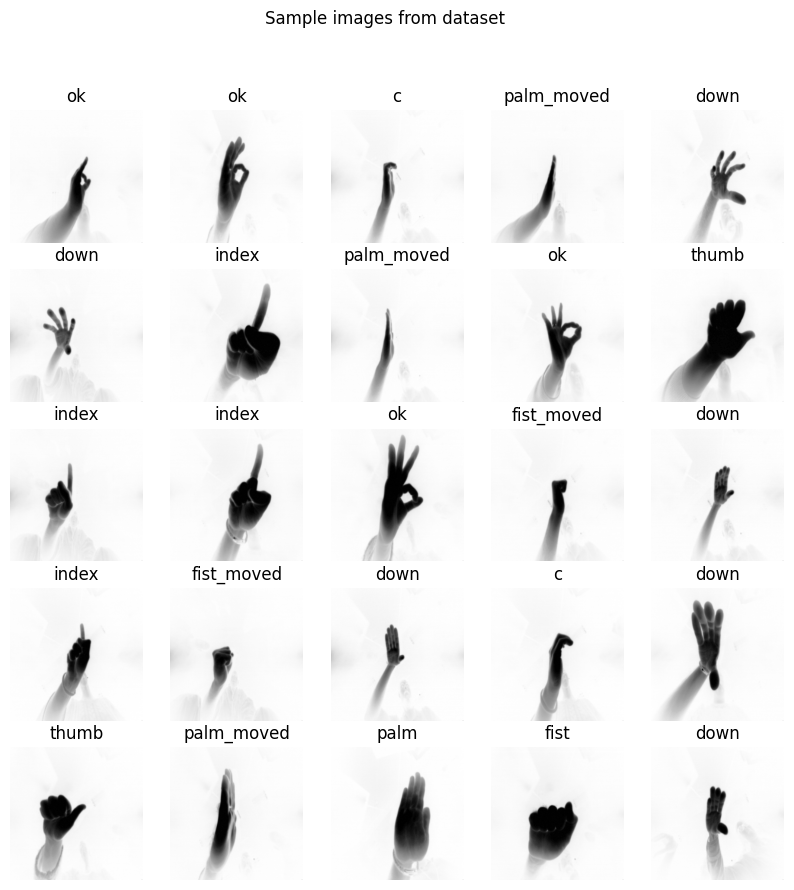

In [5]:
# Create a figure
plt.figure(figsize=(10, 10))
# Repeat 25 times
for i in range(25):
    # Get the image and label
    im_, lbl_ = dataset[i]
    # Create a subplot
    plt.subplot(5, 5, i+1)
    # Rearrage the dimensions of image [1, 224, 224] -> [224, 224, 1]
    im_ = im_.numpy().transpose(1, 2, 0)
    # Display the image in subplot
    plt.imshow(im_, cmap="binary")
    # Obtain the image label and use as title
    plt.title(dataset.inv_mapper[lbl_.argmax().item()])
    # Hide the axis
    plt.axis("off")

plt.suptitle("Sample images from dataset")

In [6]:
# Length of dataset
dataset_len = len(dataset)
# Index at 80% of data
train_split_index = int(0.8 * dataset_len)
# Index at 90% of data
val_split_index = int(0.9 * dataset_len)

# Slicing from 0 to 80%
train_set = Subset(dataset, torch.arange(0, train_split_index))
# Slicing from 80% to 90%
val_set = Subset(dataset, torch.arange(train_split_index, val_split_index))
# Slicing from 90% to 100%
test_set = Subset(dataset, torch.arange(val_split_index, dataset_len))

In [7]:
# Define batch size
BATCHSIZE = 8

# Create data loader for each split of data
# train_loader = DataLoader(dataset, sampler=train_set, batch_size=BATCHSIZE) 
train_loader = DataLoader(train_set, batch_size=BATCHSIZE) 
val_loader = DataLoader(val_set, batch_size=BATCHSIZE)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE)

In [8]:
len(train_loader), len(val_loader), len(test_loader)

(2000, 250, 250)

In [9]:
x, y = next(iter(train_loader))

## Data prep ends here

In [10]:
# Obtain resnet18 and resnet50 structure
resnet18_backbone = resnet18()
resnet50_backbone = resnet50()

In [11]:
class HandSignModel(nn.Module):
    def __init__(self, backbone=None):
        super(HandSignModel, self).__init__()
        # Input layer [1 -> 3]
        self.input_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding="same")
        self.input_layer_2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), padding="same")
        # Define backbone
        self.backbone = backbone
        # Define Fully connected layer 1 [1000 -> 500]
        self.fc1 = nn.Linear(in_features=1000, out_features=500, bias=True)
        # Fuly connected layer 2 [500 -> 100]
        self.fc2 = nn.Linear(in_features=500, out_features=100, bias=True)
        # [Output layer] Fuly connected layer 3 [100 -> 10]
        self.output_layer = nn.Linear(in_features=100, out_features=10, bias=True)
    
    def forward(self, x):
        # Pass through all layers sequentially
        x = self.input_layer(x)
        x = self.input_layer_2(x)
        x = nn.ReLU()(x)
        x = self.backbone(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        # Use softmax activation at the end
        # to convert logits to probabilities
        x = nn.Softmax(dim=1)(x)
        return x


In [12]:
# Instantiate the model
model_18 = HandSignModel(backbone=resnet18())
model_50 = HandSignModel(backbone=resnet50())

# Define loss and optimiser
criterion = nn.CrossEntropyLoss()
optimiser_18 = torch.optim.Adam(model_18.parameters(), lr=0.0001)
optimiser_50 = torch.optim.Adam(model_50.parameters(), lr=0.0001)

In [13]:
# Check the availability of device
device = ("cuda" 
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
          )

print("Using device:", device)
# move the model and loss function to device
model_18.to(device)
model_50.to(device)

criterion.to(device)

Using device: cuda


CrossEntropyLoss()

In [14]:
def train(dataloader, eval_dataloader, model, criterion, optimiser, n_epochs=10):
    """A function to train the model for given number of epochs"""
    # Total number of batches
    n_batches = len(dataloader)
    # Total number of sampels
    n_samples = n_batches * BATCHSIZE
    # Dict to store all metrics
    metrics = {}
    # Repeat for each epoch
    for epoch in range(n_epochs):
        # Create a TQDM loader for visualisation
        tqdm_loader = tqdm.tqdm(dataloader, ncols=100)
        # Set the model to train
        model.train()
        # Number of correct predictions made
        total_correct_so_far = 0
        # Create storage buckets for loss and accuracy
        metrics[epoch] = {"losses": [], "accuracies": []}
        # Repeat for each batch
        for nth_batch, (images, labels) in enumerate(tqdm_loader, 1):
            # Move the images and labels to device (CPU/MPS/CUDA)
            images = images.to(device)
            labels = labels.to(device)
            
            # Perform predictions using model
            preds = model(images)
            # Compute loss
            loss = criterion(preds, labels)
            # Extract the loss value and store it
            loss_value = loss.item()
            metrics[epoch]["losses"].append(loss_value)
            
            # Check the number of correct predictions
            n_correct = sum(preds.argmax(axis=1) == labels.argmax(axis=1))
            # Add it to the counter
            total_correct_so_far += n_correct
            # Compute accuracy (num_correct_so_far / total_samples_so_far), and store it
            cum_batch_accuracy = (total_correct_so_far) / (nth_batch * BATCHSIZE)
            metrics[epoch]["accuracies"].append(cum_batch_accuracy.item())
            # Set the desc of TQDM loader to display metrics
            tqdm_loader.set_description(f"[Epoch {epoch + 1}] {Fore.RED}Loss: {loss_value:0.3f}{Style.RESET_ALL} | {Fore.GREEN}Accuracy: {cum_batch_accuracy:0.3f}{Style.RESET_ALL}")

            # Clear the gradients
            optimiser.zero_grad()
            # Compute new gradients towards minimising loss
            loss.backward()
            # Step the optimiser by learning rate
            optimiser.step()

        # After 1 full epoch, evaluate the model on val_loader
        batch_val_loss, batch_val_acc = evaluate(eval_dataloader, model=model, criterion=criterion)
        # Obtain metrics and store them
        metrics[epoch]['val_loss'] = batch_val_loss
        metrics[epoch]['val_acc'] = batch_val_acc

    return metrics


def evaluate(dataloader, model, criterion):
    """A function to evaluate the model"""
    # Set the model to eval mode
    model.eval()
    # Create a TQDM loader for visualisation
    tqdm_loader_eval = tqdm.tqdm(dataloader, ncols=100)
    # Total number of batches
    n_batches = len(dataloader)
    # Create buckets to store loss and accuracy
    losses = []
    accuracies = []
    total_correct_so_far = 0
    # Repeat for each batch
    for nth_batch, (images, labels) in enumerate(tqdm_loader_eval, 1):
        # Move the images and labels to device (CPU/MPS/CUDA)
        images = images.to(device)
        labels = labels.to(device)
        
        # Perform predictions using model
        preds = model(images)
        # Compute loss
        loss = criterion(preds, labels)
        # Extract the loss value and store it
        loss_value = loss.item()
        losses.append(loss_value)
        
        # Check the number of correct predictions
        n_correct = sum(preds.argmax(axis=1) == labels.argmax(axis=1))
        # Add it to the counter
        total_correct_so_far += n_correct
        # Compute accuracy (num_correct_so_far / total_samples_so_far), and store it
        cum_batch_accuracy = (total_correct_so_far) / (nth_batch * BATCHSIZE)
        accuracies.append(cum_batch_accuracy.item())
        # Set the desc of TQDM loader to display metrics
        tqdm_loader_eval.set_description(f"[EVAL] {Fore.RED}Loss: {loss_value:0.3f}{Style.RESET_ALL} | {Fore.GREEN}Accuracy: {cum_batch_accuracy:0.3f}{Style.RESET_ALL}")
    
    return losses, accuracies

In [16]:
SAVE_NAME_18 = "hand_recog_resnet18"

In [15]:
# training_metrics_18 = train(train_loader, val_loader, model_18, criterion, optimiser_18, n_epochs=20)


# torch.save(model_18, SAVE_NAME_18 + ".pth")
# with open(SAVE_NAME_18 + ".metrics", "wb") as f18:
#     pickle.dump(training_metrics_18, f18)

[Epoch 1] Loss: 1.656 | Accuracy: 0.742: 100%|██████████████████| 2000/2000 [01:34<00:00, 21.09it/s]
[EVAL] Loss: 1.654 | Accuracy: 0.933: 100%|███████████████████████| 250/250 [00:09<00:00, 26.80it/s]
[Epoch 2] Loss: 1.518 | Accuracy: 0.962: 100%|██████████████████| 2000/2000 [01:34<00:00, 21.14it/s]
[EVAL] Loss: 1.461 | Accuracy: 0.989: 100%|███████████████████████| 250/250 [00:09<00:00, 26.70it/s]
[Epoch 3] Loss: 1.462 | Accuracy: 0.968: 100%|██████████████████| 2000/2000 [01:34<00:00, 21.09it/s]
[EVAL] Loss: 1.461 | Accuracy: 0.990: 100%|███████████████████████| 250/250 [00:09<00:00, 26.56it/s]
[Epoch 4] Loss: 1.461 | Accuracy: 0.980: 100%|██████████████████| 2000/2000 [01:35<00:00, 20.89it/s]
[EVAL] Loss: 1.461 | Accuracy: 0.996: 100%|███████████████████████| 250/250 [00:09<00:00, 26.45it/s]
[Epoch 5] Loss: 1.461 | Accuracy: 0.980: 100%|██████████████████| 2000/2000 [01:36<00:00, 20.80it/s]
[EVAL] Loss: 1.461 | Accuracy: 0.998: 100%|███████████████████████| 250/250 [00:09<00:00, 2

In [17]:
SAVE_NAME_50 = "hand_recog_resnet50"

In [16]:
# training_metrics_50 = train(train_loader, val_loader, model_50, criterion, optimiser_50, n_epochs=20)


# torch.save(model_50, SAVE_NAME_50 + ".pth")
# with open(SAVE_NAME_50 + ".metrics", "wb") as f50:
#     pickle.dump(training_metrics_50, f50)

[Epoch 1] Loss: 2.077 | Accuracy: 0.443: 100%|██████████████████| 2000/2000 [03:25<00:00,  9.76it/s]
[EVAL] Loss: 1.777 | Accuracy: 0.607: 100%|███████████████████████| 250/250 [00:12<00:00, 19.33it/s]
[Epoch 2] Loss: 1.956 | Accuracy: 0.610: 100%|██████████████████| 2000/2000 [03:22<00:00,  9.85it/s]
[EVAL] Loss: 2.084 | Accuracy: 0.766: 100%|███████████████████████| 250/250 [00:13<00:00, 19.10it/s]
[Epoch 3] Loss: 1.583 | Accuracy: 0.762: 100%|██████████████████| 2000/2000 [03:25<00:00,  9.74it/s]
[EVAL] Loss: 1.701 | Accuracy: 0.887: 100%|███████████████████████| 250/250 [00:13<00:00, 18.84it/s]
[Epoch 4] Loss: 1.583 | Accuracy: 0.828: 100%|██████████████████| 2000/2000 [03:25<00:00,  9.71it/s]
[EVAL] Loss: 1.709 | Accuracy: 0.859: 100%|███████████████████████| 250/250 [00:13<00:00, 18.61it/s]
[Epoch 5] Loss: 1.461 | Accuracy: 0.885: 100%|██████████████████| 2000/2000 [03:25<00:00,  9.73it/s]
[EVAL] Loss: 1.646 | Accuracy: 0.986: 100%|███████████████████████| 250/250 [00:13<00:00, 1

In [15]:
model18 = torch.load("hand_recog_resnet18.pth")
model50 = torch.load("hand_recog_resnet50.pth")

In [18]:
with open(SAVE_NAME_18 + ".metrics", "rb") as f18:
    training_metrics_18 = pickle.load(f18)

with open(SAVE_NAME_50 + ".metrics", "rb") as f50:
    training_metrics_50 = pickle.load(f50)

In [19]:
mean_metrics_18 = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
for epoch, epoch_dict in training_metrics_18.items():
    mean_metrics_18["loss"].append(np.mean(epoch_dict['losses']))
    mean_metrics_18["accuracy"].append(np.mean(epoch_dict['accuracies']))
    mean_metrics_18["val_loss"].append(np.mean(epoch_dict['val_loss']))
    mean_metrics_18["val_accuracy"].append(np.mean(epoch_dict['val_acc']))

mean_metrics_18 = pd.DataFrame(mean_metrics_18)

mean_metrics_50 = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
for epoch, epoch_dict in training_metrics_50.items():
    mean_metrics_50["loss"].append(np.mean(epoch_dict['losses']))
    mean_metrics_50["accuracy"].append(np.mean(epoch_dict['accuracies']))
    mean_metrics_50["val_loss"].append(np.mean(epoch_dict['val_loss']))
    mean_metrics_50["val_accuracy"].append(np.mean(epoch_dict['val_acc']))

mean_metrics_50 = pd.DataFrame(mean_metrics_50)

In [20]:
mean_metrics_18

,loss,accuracy,val_loss,val_accuracy
0,1.724685,0.559568,1.534233,0.933956
1,1.501834,0.949879,1.472957,0.990796
2,1.493377,0.970272,1.471612,0.992685
3,1.481284,0.983056,1.466015,0.996880
4,1.481864,0.977846,1.463452,0.997098
5,1.479953,0.982409,1.463520,0.996250
6,1.472467,0.986808,1.464731,0.998445
7,1.477035,0.984006,1.464321,0.997778
8,1.473012,0.983269,1.462728,0.998816
9,1.477657,0.981006,1.463144,0.998775


In [21]:
mean_metrics_50

,loss,accuracy,val_loss,val_accuracy
0,2.013092,0.336075,1.855410,0.611263
1,1.849759,0.587685,1.696357,0.765638
2,1.697884,0.736225,1.573069,0.887372
3,1.633007,0.823529,1.602010,0.871513
4,1.575758,0.859795,1.476012,0.988006
5,1.528423,0.937352,1.472002,0.988376
6,1.515211,0.951457,1.471587,0.989345
7,1.504411,0.949308,1.486108,0.977767
8,1.507168,0.956251,1.541862,0.916570
9,1.515347,0.946788,1.561344,0.897191


Text(0.5, 0.98, 'Model with resnet18 backbone')

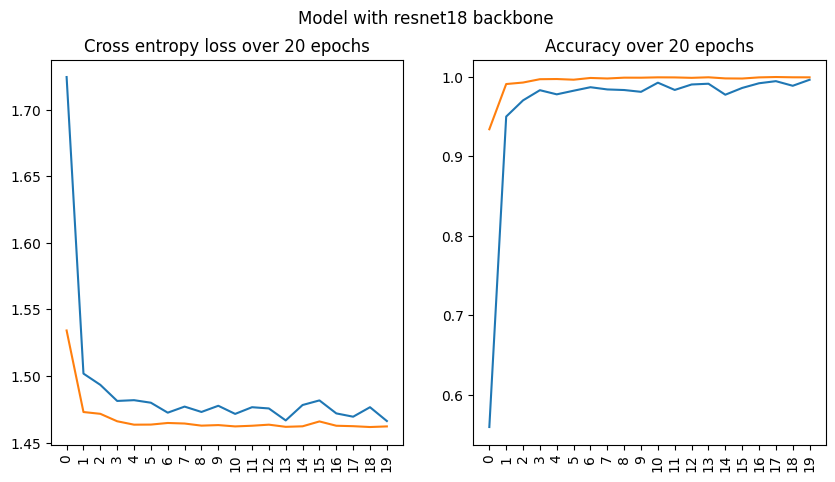

In [22]:
x_range = mean_metrics_18.shape[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(x_range), mean_metrics_18['loss'])
plt.plot(range(x_range), mean_metrics_18['val_loss'])
plt.xticks(range(x_range), rotation=90)
plt.title(f"Cross entropy loss over {x_range} epochs")
plt.subplot(1, 2, 2)
plt.plot(range(x_range), mean_metrics_18['accuracy'])
plt.plot(range(x_range), mean_metrics_18['val_accuracy'])
plt.xticks(range(x_range), rotation=90)
plt.title(f"Accuracy over {x_range} epochs")
plt.suptitle("Model with resnet18 backbone")

Text(0.5, 0.98, 'Model with resnet50 backbone')

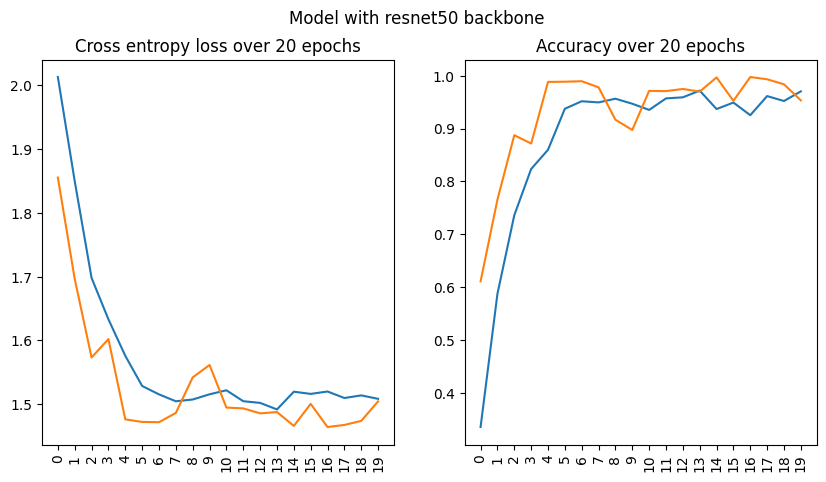

In [23]:
x_range = mean_metrics_50.shape[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(x_range), mean_metrics_50['loss'])
plt.plot(range(x_range), mean_metrics_50['val_loss'])
plt.xticks(range(x_range), rotation=90)
plt.title(f"Cross entropy loss over {x_range} epochs")
plt.subplot(1, 2, 2)
plt.plot(range(x_range), mean_metrics_50['accuracy'])
plt.plot(range(x_range), mean_metrics_50['val_accuracy'])
plt.xticks(range(x_range), rotation=90)
plt.title(f"Accuracy over {x_range} epochs")
plt.suptitle("Model with resnet50 backbone")

In [24]:
test_metrics_18 = evaluate(test_loader, model18, criterion)

[EVAL] Loss: 1.461 | Accuracy: 0.999: 100%|███████████████████████| 250/250 [00:31<00:00,  7.84it/s]


In [25]:
test_metrics_50 = evaluate(test_loader, model50, criterion)

[EVAL] Loss: 1.586 | Accuracy: 0.967: 100%|███████████████████████| 250/250 [00:11<00:00, 21.52it/s]
